# CRAFTML

The CRAFTML Rust implementation can be found here: https://github.com/tomtung/craftml-rs

And the paper can be found here: http://proceedings.mlr.press/v80/siblini18a/siblini18a.pdf

To run the code:

1. Install Rust from the website here: https://www.rust-lang.org/
2. Then, clone the github into a local directory adjacent to this one (so that they both have the same parent folder).
3. Follow the instruction on the github to build the rust program
4. Download the Eurlex 4k dataset from the Extreme Multilabel repository (or use the Eurlex data folder in our project github)
 1.  If you downloaded it from the extreme multilabel repository, make sure to run the cross validation code (the second code cell) to build the cv data sets. If not, then skip this code cell.
5. Then, you should be able to run the rest of the code just fine.



In [156]:
import os
import pandas as pd
import numpy as np
np.random.seed(2020)
import pickle
from itertools import cycle, product
from sklearn.metrics import label_ranking_average_precision_score
import time
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

num_features = 5000
num_labels = 3993
num_samples_val = 3809
num_samples_train = 15539

cv_idx = np.random.randint(5, size = num_samples_train)
cv_counts = np.unique(cv_idx, return_counts = True)[1]
results = dict()

The below code block sets up the cross validation folds in the format that the craftml implementation needs.
Each input file should be of the form:
```
num_examples num_total_features num_total_labels
label1,label2,... feature1:score1 feature2:score2 ...
```

Which is how the txt file looks like if you download it from the Extreme Classification Repository http://manikvarma.org/downloads/XC/XMLRepository.html

All of the cross validation data sets are saved in the Eurlex folder (along with the train and dev sets

In [ ]:
# # write first line to each cv val and train file
# # first line is 'num_samples num_features num_labels'
# for i in range(5):
#     file_name = 'Eurlex/cv_' + str(i) + '_val'
#     with open(file_name, 'w') as file:
#         file.write(str(cv_counts[i]) + ' ' + str(num_features) + ' ' + str(num_labels) + '\n')
        
#     file_name = 'Eurlex/cv_' + str(i) + '_train'
#     with open(file_name, 'w') as file:
#         file.write(str(num_samples_train - cv_counts[i]) + ' ' + str(num_features) +
#                    ' ' + str(num_labels) + '\n')

# with open('Eurlex/eurlex_train.txt', 'r') as f:
#     for i, line in enumerate(f):
#         if(i == 0):
#             continue
#         for j in range(5):
#             if j == cv_idx[i-1]:
#                 file_name = 'Eurlex/cv_' + str(j) + '_val'
#             else:
#                 file_name = 'Eurlex/cv_' + str(j) + '_train'
#             with open(file_name, 'a') as file:
#                 file.write(line)

Training using 5 fold cross validation and grid-search for hyperparameter tuning

In [7]:
train_cmd_call = '../craftml-rs/target/release/craftml train --model_path model.m'
val_cmd_call = '../craftml-rs/target/release/craftml test --out_path predictions.txt --k_top ' + str(num_labels) + ' model.m '
k_clusters_list = [10]
n_trees_list = [200]
cluster_sample_list = [500, 2000, 20000]
hyper_parameter_grid = product(k_clusters_list, n_trees_list, cluster_sample_list, centroid_min_n_preserve_list)

start = time.time()
for k_clusters, n_trees, cluster_size, centroid_min in hyper_parameter_grid:
    
    # build the command line call to train the model
    cv_cmd_train = train_cmd_call + ' --k_clusters ' + str(k_clusters) + ' --n_trees ' + str(n_trees) + \
                    ' --cluster_sample_size ' + str(cluster_size) + \
                    str(centroid_min) + ' --n_feature_buckets 1000 --n_label_buckets 1000'
    # results for each cv-fold
    param_results = np.zeros(5)
    for i in range(5):
        train_file_name = 'Eurlex/cv_' + str(i) + '_train'
        val_file_name = 'Eurlex/cv_' + str(i) + '_val'
        # add the correct cv file to the end of the cmd line call for train
        cv_ith_cmd_train = cv_cmd_train + ' ' + train_file_name
        # call the command
        os.system(cv_ith_cmd_train)
        # add correct cv file to the end of the cmd line for test
        cv_ith_cmd_val = val_cmd_call + val_file_name
        # call the command
        os.system(cv_ith_cmd_val)
        # create the predictions matrix 
        predictions = np.zeros((cv_counts[i], num_labels))
        with open('predictions.txt') as f:
            for j, line in enumerate(f):
                for val in line.split(sep = '\t'):
                    label, prob = val.split(sep = ' ')
                    label = int(label)
                    prob = float(prob)
                    predictions[j, label] = prob
        
        # create the true labels matrix
        true_labels = np.zeros((cv_counts[i], num_labels))
        with open(val_file_name, 'r') as f:
            for j, line in enumerate(f):
                if(j == 0):
                    continue
                label_string = line.split(sep = ' ')[0]
                if(label_string == ''):
                    continue
                labels = label_string.split(sep = ',')
                for label in labels:
                    true_labels[j-1,int(label)] = 1
        # take the LRAP score
        lrap_cv = label_ranking_average_precision_score(true_labels, predictions)
        print(k_clusters, n_trees, i, lrap_cv)
        param_results[i] = lrap_cv
    
    dict_key = str(k_clusters) + ',' + str(n_trees) + ',' + str(cluster_size) + ',' + str(centroid_min)
    results[dict_key] = param_results.mean()
print('time:', time.time() -start)

10 200 0 0.5639978334098736
10 200 1 0.5704668430345953
10 200 2 0.5706352303281924
10 200 3 0.577827386511241
10 200 4 0.5686751374767613
10 200 0 0.5639215449069319
10 200 1 0.569568964082095
10 200 2 0.5691881753084554
10 200 3 0.5763593244390124
10 200 4 0.5698666431004868
10 200 0 0.5634969750339635
10 200 1 0.5693041852255568
10 200 2 0.568932528556886
10 200 3 0.5762825928036376
10 200 4 0.5689834161167213
time: 2229.006737947464


In [22]:
results_df

,k_clusters,n_trees,sample_size,score
0,10,25,1000,0.551262
1,10,50,1000,0.561229
2,10,75,1000,0.565327
3,10,100,1000,0.566787
4,10,150,1000,0.568993
5,10,200,1000,0.570056
6,5,25,1000,0.546596
7,5,50,1000,0.556832
8,5,75,1000,0.560221
9,5,100,1000,0.561896


In [54]:
results_df = pd.read_csv('predictions_tsv.txt', sep = '\t', index_col = 0)
results_df.columns

Index(['k_clusters', 'n_trees', 'sample_size', 'score'], dtype='object')

In [42]:
# results_df = pd.DataFrame(columns = ['k_clusters', 'n_trees', 'sample_size', 'score'])
# for key,value in results.items():
#     k_cluster, n_trees, sample_size, _ = key.split(',')
#     results_df = results_df.append({'k_clusters':int(k_cluster), 'n_trees': int(n_trees), 
#                                     'sample_size':int(sample_size), 'score':value},
#                       ignore_index = True)

# results_df

,k_clusters,n_trees,sample_size,score


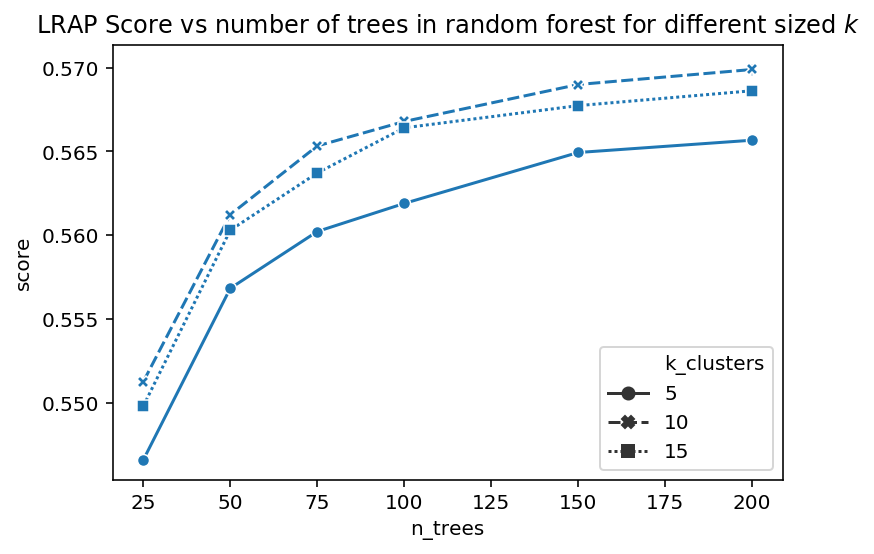

In [157]:
sns.lineplot(x = 'n_trees', y = 'score', data = results_df, style = 'k_clusters', markers = True)
plt.title('LRAP Score vs number of trees in random forest for different sized $k$')
plt.show()

Testing dev dataset on the best hyperparameters

In [191]:
# best parameters: 200 trees, max_leaf 10, centroid preserve 500, cluster sample size 1000
# n_feature buckets 1000, n_label_buckets 1000 (these last two are cited in the paper to be the best for the
# Eurlex 4K dataset)
train_cmd_call = '../craftml-rs/target/release/craftml train --model_path model.m --cluster_sample_size 500'+\
                 ' --leaf_max_size 10 --n_trees 200 --n_feature_buckets 1000 --n_label_buckets 1000'+\
                 ' Eurlex/eurlex_train.txt'

val_cmd_call = '../craftml-rs/target/release/craftml test --out_path predictions.txt --k_top ' +\
                str(num_labels) + ' model.m Eurlex/dev.txt'
start = time.time()
os.system(train_cmd_call)
os.system(val_cmd_call)
predictions = np.zeros((1316, num_labels))
with open('predictions.txt') as f:
    for j, line in enumerate(f):
        for val in line.split(sep = '\t'):
            label, prob = val.split(sep = ' ')
            label = int(label)
            prob = float(prob)
            predictions[j, label] = prob

true_labels = np.zeros((1316, num_labels))
with open('Eurlex/dev.txt', 'r') as f:
    for j, line in enumerate(f):
        if(j == 0):
            continue
        label_string = line.split(sep = ' ')[0]
        if(label_string == ''):
            continue
        labels = label_string.split(sep = ',')
        for label in labels:
            true_labels[j-1,int(label)] = 1
lrap= label_ranking_average_precision_score(true_labels, predictions)
print(lrap)
print('time:', time.time() - start)

0.5872840963394884
time: 75.44249987602234


Looking at jaccard, precision, and recall

In [189]:
thresholds = np.linspace(0,1, 101)
precision_list = []
recall_list = []
jaccard_list = []
for threshold in thresholds:
    
    num_correct = ((predictions >= threshold) & (true_labels == 1)).sum(axis  = 1).astype(float)
    total_num = ((predictions >= threshold) | (true_labels == 1)).sum(axis=1).astype(float)
    true_num_labels = true_labels.sum(axis = 1).astype(float)
    prediction_num_labels = (predictions >= threshold).sum(axis = 1).astype(float)
#     precision = np.divide(num_correct, prediction_num_labels,
#                         out = np.ones_like(prediction_num_labels), where = prediction_num_labels!=0)
    precision = num_correct/prediction_num_labels
    precision_list.append(precision[~np.isnan(precision)].mean())
#     recall = np.divide(num_correct, true_num_labels,
#                         out = np.ones_like(true_num_labels), where = true_num_labels!=0)
    recall = num_correct/true_num_labels
    recall_list.append(recall[~np.isnan(recall)].mean())
#     jaccard = np.divide(num_correct, total_num, out = np.ones_like(total_num), 
#                        where = total_num != 0)
    jaccard = num_correct/total_num
    jaccard_list.append(jaccard[~np.isnan(jaccard)].mean())
    

/home/aidanclaffey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/aidanclaffey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/aidanclaffey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/aidanclaffey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aidanclaffey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


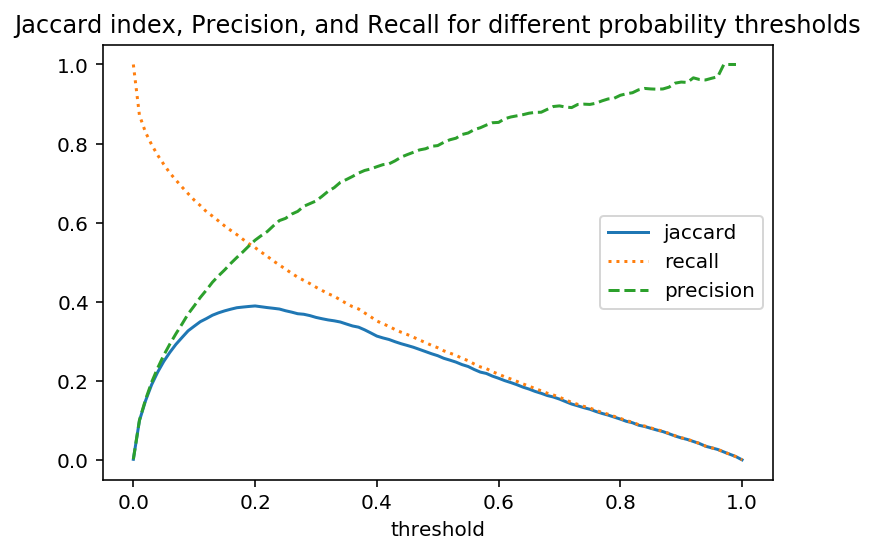

Best precision threshold:  0.5555775243275244
Best Jaccard index threshold:  0.2


In [190]:
plt.plot(thresholds, jaccard_list, linestyle = '-', label = 'jaccard')
plt.plot(thresholds, recall_list, linestyle = ':', label = 'recall')
plt.plot(thresholds, precision_list, linestyle = '--', label = 'precision')
plt.xlabel('threshold')
plt.legend()
plt.title('Jaccard index, Precision, and Recall for different probability thresholds')
plt.show()

print('Best precision threshold: ', precision_list[np.argmax(jaccard_list)])
print('Best Jaccard index threshold: ', thresholds[np.argmax(jaccard_list)])


Turn test set into usable format

In [233]:
with open('data/test_no_label.csv', 'r') as f:
    with open('data/test_no_label.txt', 'w') as f_write:
        f_write.write('2489 5000 2993\n')
        for i, line in enumerate(f):
            if i == 0:
                continue
            if line[0] == '"':
                continue
            split = line.split(',')
            f_write.write(' ' + split[2][1:])

In [ ]:
Run prediction of model on test set

In [234]:
# best parameters: 200 trees, max_leaf 10, centroid preserve 500, cluster sample size 1000
# n_feature buckets 1000, n_label_buckets 1000 (these last two are cited in the paper to be the best for the
# Eurlex 4K dataset)
train_cmd_call = '../craftml-rs/target/release/craftml train --model_path model.m --cluster_sample_size 500'+\
                 ' --leaf_max_size 10 --n_trees 200 --n_feature_buckets 1000 --n_label_buckets 1000'+\
                 ' Eurlex/eurlex_train.txt'

val_cmd_call = '../craftml-rs/target/release/craftml test --out_path predictions.txt --k_top ' +\
                str(num_labels) + ' model.m data/test_no_label.txt'
start = time.time()
os.system(train_cmd_call)
os.system(val_cmd_call)
predictions = np.zeros((2489, num_labels))
with open('predictions.txt') as f:
    for j, line in enumerate(f):
        for val in line.split(sep = '\t'):
            label, prob = val.split(sep = ' ')
            label = int(label)
            prob = float(prob)
            predictions[j, label] = prob
            


In [235]:
predictions.tofile('test_predictions_final.csv', sep = ',')